# Plano Inclinado con Fricción (Newton)

In [1]:
%reset -f
import sympy as smp
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

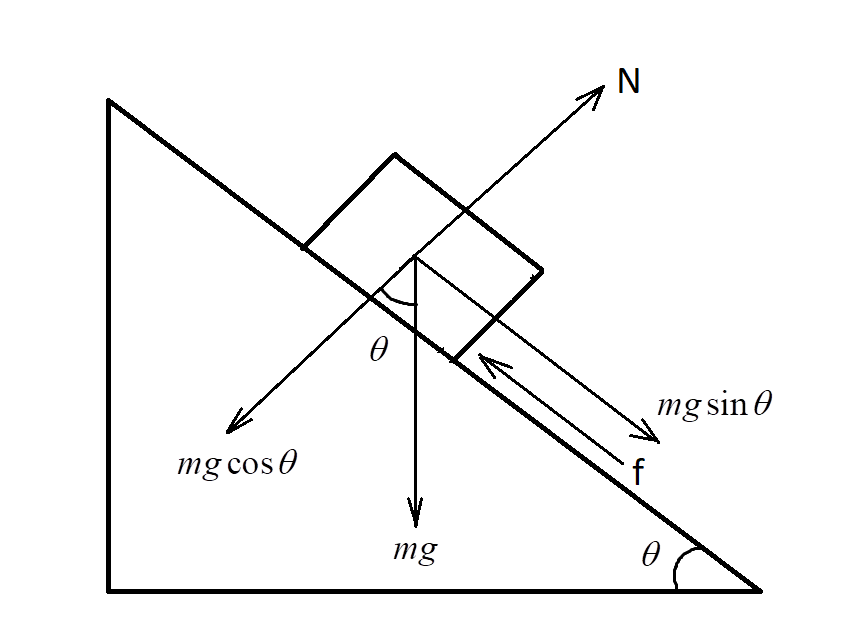

Define los simbolos apropiados en sympy

In [2]:
t, g, m, theta, mu = smp.symbols(r't g m \theta \mu', positive=True)

$$\vec{F} = m\vec{a}$$

Primero calculamos la fuerza Normal que está en equilibrio con la componente vertical de la fuerza de la gravedad

$$F_N - mg\cos\theta = 0$$ <br>
$$\implies F_N = mg\cos\theta$$

In [3]:
FN = m * g * smp.cos(theta)
FN

g*m*cos(\theta)

Por lo que la fuerza de fricción es <br>
$$F_r = -\mu F_N$$

In [4]:
Fr = -mu * FN
Fr

-\mu*g*m*cos(\theta)

Al ser caída libre solo tenemos una componente para la aceleración y la fuerza

$$F_{x} = ma_{x}$$

$x$ es una función dependiente del tiempo

In [5]:
x = smp.Function('x', real=True)
x = x(t)

Definimos las dos primeras derivadas temporales de $x$

In [6]:
d1_x = smp.diff(x, t)
d2_x = smp.diff(d1_x, t)

La fuerza de gravedad que causa el movimiento solo actúa a lo largo del eje $x$ al igual que la de fricción

$$F_x = mg\sin\theta + F_r$$

In [7]:
Fx = m*g*smp.sin(theta) + Fr
Fx

-\mu*g*m*cos(\theta) + g*m*sin(\theta)

La aceleracíon es: $a = \ddot{x}$ <br>
Esto nos deja con la siguiente ecuación de movimiento:

$$F_{x} = ma_{x}$$

In [8]:
Eq = smp.Eq(Fx, m*d2_x)
Eq

Eq(-\mu*g*m*cos(\theta) + g*m*sin(\theta), m*Derivative(x(t), (t, 2)))

## Solución Exacta (dsolve)

In [9]:
Eq

Eq(-\mu*g*m*cos(\theta) + g*m*sin(\theta), m*Derivative(x(t), (t, 2)))

Otra forma de resolver la ecuación de movimiento es resolviendo directamente y de forma simbólica con la función **dsolve**

In [10]:
x_explicit = smp.dsolve(Eq, x).args[1]
x_explicit

C1 + C2*t + g*t**2*(-\mu*cos(\theta) + sin(\theta))/2

Derivando dos veces la ecuación obtenida podemos obtener la velocidad y la aceleración

In [11]:
d1_x_explicit = smp.diff(x_explicit, t)
d1_x_explicit

C2 + g*t*(-\mu*cos(\theta) + sin(\theta))

## Solución Exacta con Condiciones Iniciales (dsolve)

In [12]:
Eq

Eq(-\mu*g*m*cos(\theta) + g*m*sin(\theta), m*Derivative(x(t), (t, 2)))

**dsolve** también se puede utilizar para resolver las ecuaciones diferenciales usando valores iniciales <br>
Estos valores iniciales tienen que guardarse en un diccionario

In [13]:
t0 = 0
x0 = 0
vx0 = 0
S0 = {x.subs(t, t0):x0, d1_x.subs(t, t0):vx0}

Con este método ya no aparecen las constantes de integración

In [14]:
x_explicit = smp.dsolve(Eq, x, ics=S0).args[1]
x_explicit

g*t**2*(-\mu*cos(\theta) + sin(\theta))/2

Derivando se puede obtener la velocidad y la aceleración

In [15]:
d1_x_explicit = smp.diff(x_explicit, t)
d1_x_explicit

g*t*(-\mu*cos(\theta) + sin(\theta))

La solución de la ecuación de movimiento (y la velocidad) es casi la misma que las anteriores, a esta se le definieron condiciones iniciales, ahora las transformamos en funciones de python-numpy con **lambdify**

In [16]:
x_exact = smp.lambdify((t, g, theta, mu), x_explicit, modules='numpy')
d1_x_exact = smp.lambdify((t, g, theta, mu), d1_x_explicit, modules='numpy')

Creamos un intervalo del tiempo en el que queremos evaluar la solución y otras propiedades como la masa y la aceleración de la gravedad

In [17]:
t0 = 0
tf = 4
t_size = 1001
t = np.linspace(t0, tf, t_size)

In [18]:
g = 9.81
theta = np.pi/6
mu = 0.5

Evaluamos la velcidad y la posición

In [19]:
x_sol_exact = x_exact(t, g, theta, mu)
d1_x_sol_exact = d1_x_exact(t, g, theta, mu)

Graficamos

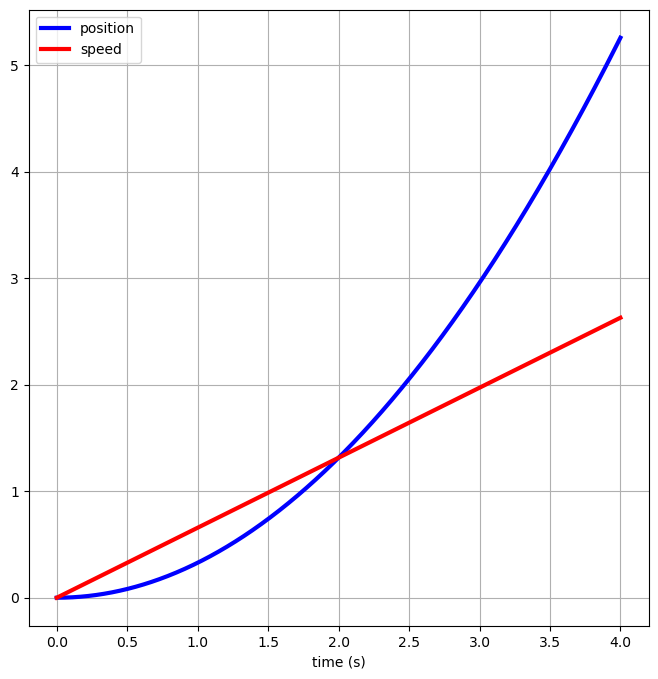

In [20]:
plt.figure(figsize=(8, 8))

plt.plot(t, x_sol_exact, lw=3, c='blue', label='position')
plt.plot(t, d1_x_sol_exact, lw=3, c='red', label='speed')

plt.xlabel('time (s)')
plt.legend()
plt.grid()
plt.show()

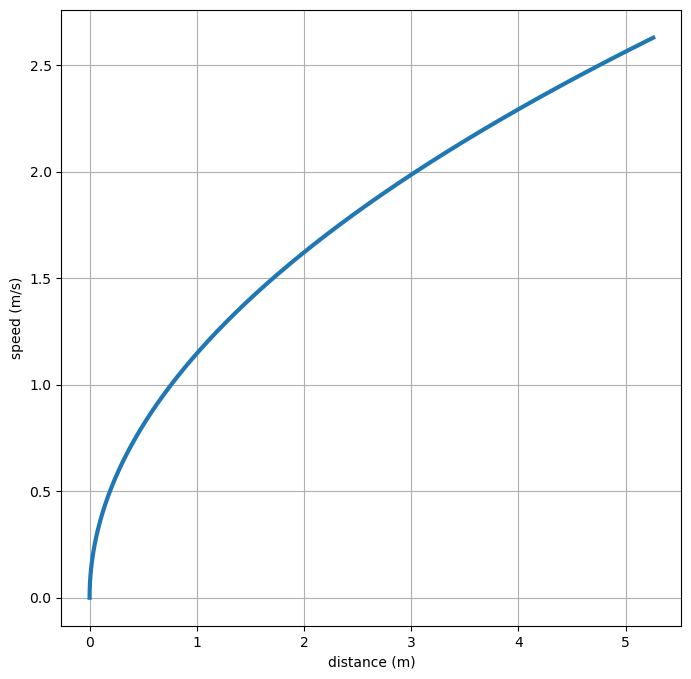

In [21]:
plt.figure(figsize=(8, 8))

plt.plot(x_sol_exact, d1_x_sol_exact, lw=3)

plt.xlabel('distance (m)')
plt.ylabel('speed (m/s)')
plt.grid()
plt.show()

## Solución Numerica

Volvemos a definir algunos simbolos ya que los habíamos sobre-escrito

In [22]:
t, g, theta, mu = smp.symbols(r't g \theta \mu', positive=True)

Recordemos el despeje de la segunda derivada de $\ddot{y}$

In [23]:
Eq

Eq(-\mu*g*m*cos(\theta) + g*m*sin(\theta), m*Derivative(x(t), (t, 2)))

In [24]:
d2_x_explicit = smp.solve([Eq], [d2_x])[d2_x]
d2_x_explicit

-\mu*g*cos(\theta) + g*sin(\theta)

Para resolver numericamente la ecuación de segundo orden se tiene que transformar en un sistema de ecuaciones de primer orde, para eso realizamos la siguiente sustitución <br>
<ul>
  <li>$\dot{x} = z$</li>
  <li>$\dot{z} = \ddot{x} = ...$</li>
</ul> 
y este sistema lo transformamos en funciones númericas

In [25]:
dx_dt_f = smp.lambdify(d1_x, d1_x, modules='numpy')
dz_dt_f = smp.lambdify((g, theta, mu), d2_x_explicit, modules='numpy')

Se define un vector $\vec{S} = (x, z)$ y una función que toma $\vec{S}$ y $t$, y devuelve $\dot{S}$ para poder resolver el sistema de ecuaciones

In [26]:
def dSdt(t, S, g, theta, mu):
    x, z = S
    return [
        dx_dt_f(z),
        dz_dt_f(g, theta, mu)
    ]

Definimos un arreglo de puntos en el tiempo en el cual queremos obtener la solución

In [27]:
t0 = 0
tf = 4
t_size = 1001
t = np.linspace(t0, tf, t_size)

Se definen algunas constantes (aceleración de la gravedad y masa) que se guardan en la lista args y se definen las condiciones iniciales (posición:y0, velocidad: vy0) que se guardan en la lista S0

In [28]:
g = 9.81
theta = np.pi/6
mu = 0.5
args = [g, theta, mu]
x0 = 0
vx0 = 0
S0 = [x0, vx0]

Se utiliza la función solve_ivp para resolver la ecuación diferencial

In [29]:
sol = solve_ivp(dSdt, t_span=(t0, tf), y0=S0, method='RK45', t_eval=t, args=args)

Guardamos la solución y se grafica

In [30]:
x_sol_numeric = sol.y[0]
d1_x_sol_numeric = sol.y[1]

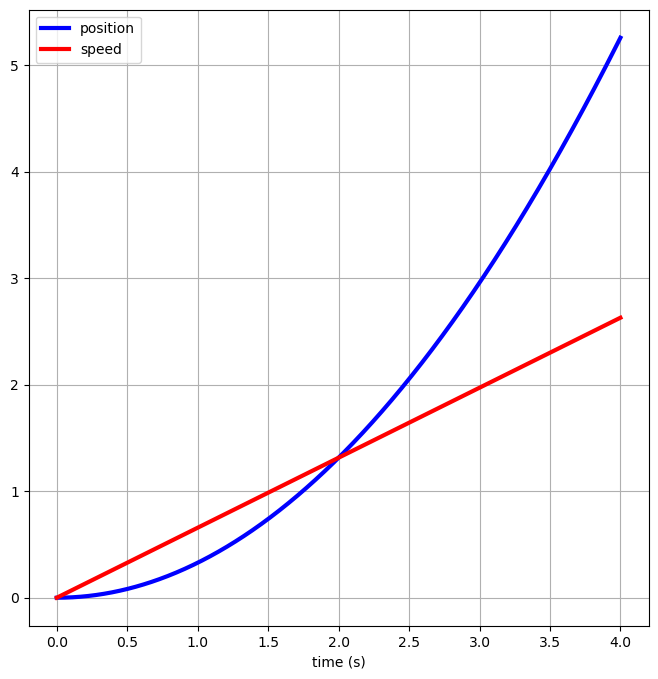

In [31]:
plt.figure(figsize=(8, 8))

plt.plot(t, x_sol_numeric, lw=3, c='blue', label='position')
plt.plot(t, d1_x_sol_numeric, lw=3, c='red', label='speed')

plt.xlabel('time (s)')
plt.legend()
plt.grid()
plt.show()

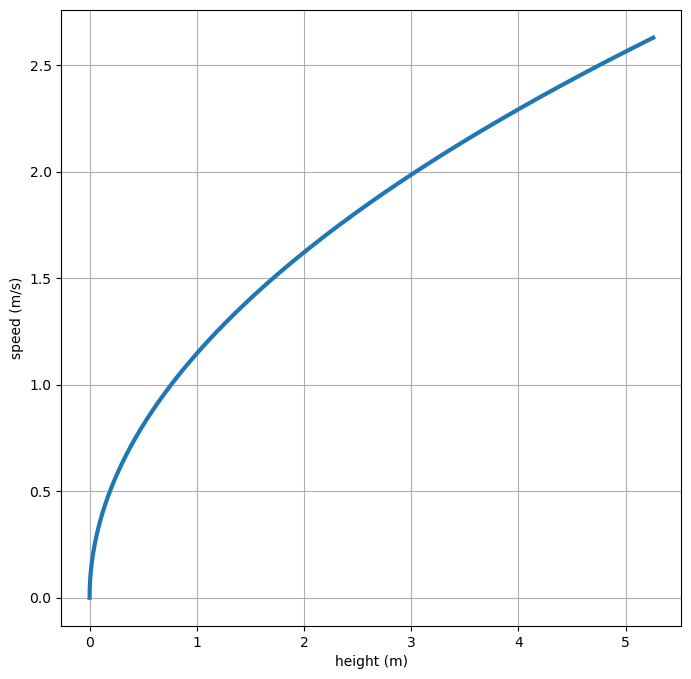

In [32]:
plt.figure(figsize=(8, 8))
plt.plot(x_sol_numeric, d1_x_sol_numeric, lw=3)
plt.xlabel('height (m)')
plt.ylabel('speed (m/s)')
plt.grid()
plt.show()

## Solución Exacta vs Numerica

Comparamos la solución exacta y númerica para la posición, velocidad y gráfica de fase, los resultados son identicos, esto se debe a la simpleza del problema

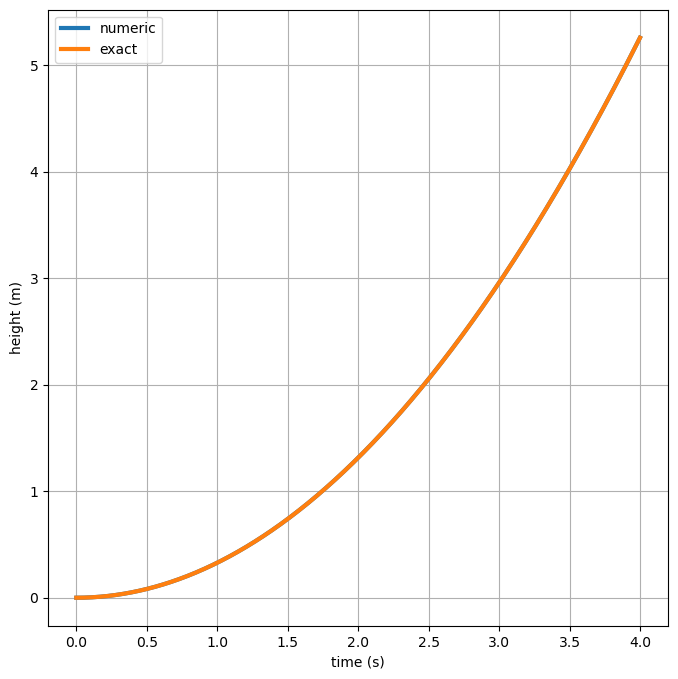

In [33]:
plt.figure(figsize=(8, 8))
plt.plot(t, x_sol_numeric, lw=3, label='numeric')
plt.plot(t, x_sol_exact, lw=3, label='exact')
plt.xlabel('time (s)')
plt.ylabel('height (m)')
plt.legend()
plt.grid()
plt.show()

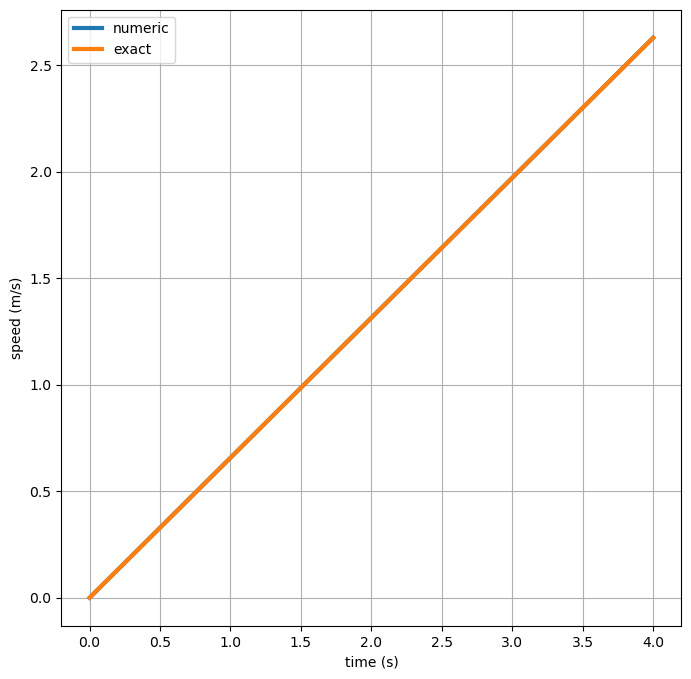

In [34]:
plt.figure(figsize=(8, 8))
plt.plot(t, d1_x_sol_numeric, lw=3, label='numeric')
plt.plot(t, d1_x_sol_exact, lw=3, label='exact')
plt.xlabel('time (s)')
plt.ylabel('speed (m/s)')
plt.legend()
plt.grid()
plt.show()

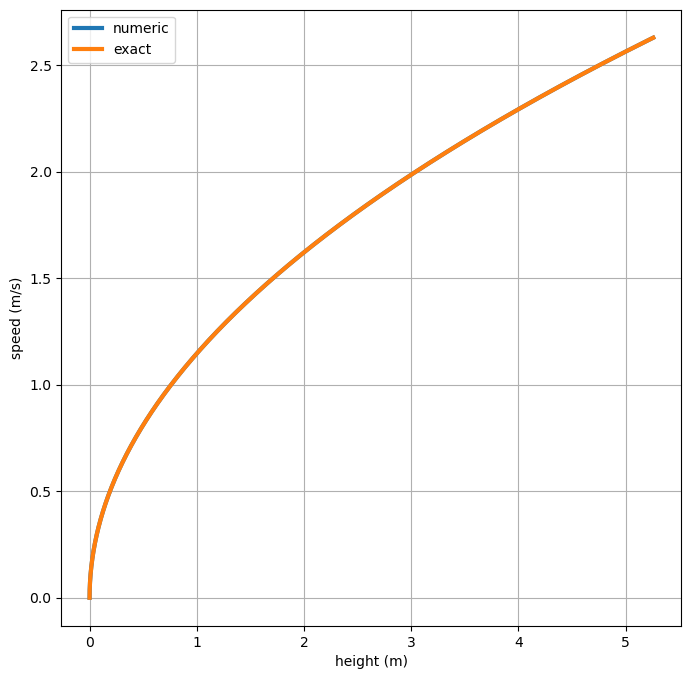

In [35]:
plt.figure(figsize=(8, 8))
plt.plot(x_sol_numeric, d1_x_sol_numeric, lw=3, label='numeric')
plt.plot(x_sol_exact, d1_x_sol_exact, lw=3, label='exact')
plt.xlabel('height (m)')
plt.ylabel('speed (m/s)')
plt.legend()
plt.grid()
plt.show()

## X e Y en marco de referencia sin rotar y trasladar

El marco de referencia escogido se encuentra en el bloque y para hallar el marco de referencia sin rotar solo tenemos que proyectar los valores de $x$ e $y$ obtenidos en nuestra solución ($y$ en especifico se tiene que trasladar). <br>

En nuestro marco usado solo nos movemos a lo largo de la hipotenusa que corresponde al eje $x$, en ese caso nuestra nueva $X = x\cos\theta$ <br>
Mientras que para nuestra nueva $Y$ tenemos que proyectar y trasladar, suponiendo que nuestro plano inclinado tiene una altura $h$ entonces nuestra nueva $Y = h -x\sin\theta$

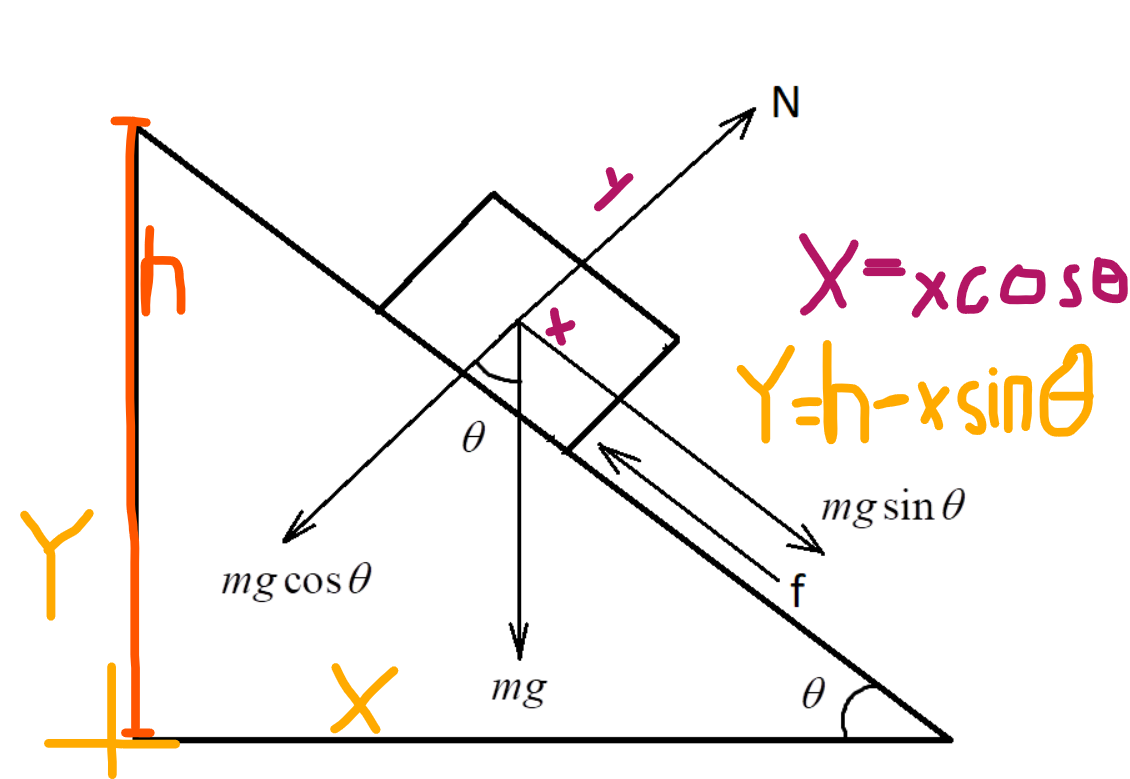

Ahora calculamos la forma simbólica de $X$ e $Y$

### Simbólica

In [36]:
theta, h = smp.symbols(r'\theta h')

In [37]:
X = x_explicit*smp.cos(theta)
X

g*t**2*(-\mu*cos(\theta) + sin(\theta))*cos(\theta)/2

In [38]:
Y = h - x_explicit*smp.sin(theta)
Y

-g*t**2*(-\mu*cos(\theta) + sin(\theta))*sin(\theta)/2 + h

Se podría sustituir $h$ y evaluar la función para graficar, pero eso lo haremos con la solución númerica obtenida o la simbólica que ya fue evaluada

### Numérica

In [39]:
theta = np.pi/6
h = 50

In [40]:
X_sol_numeric = x_sol_numeric * np.cos(theta)
Y_sol_numeric = h - (x_sol_numeric * np.sin(theta))

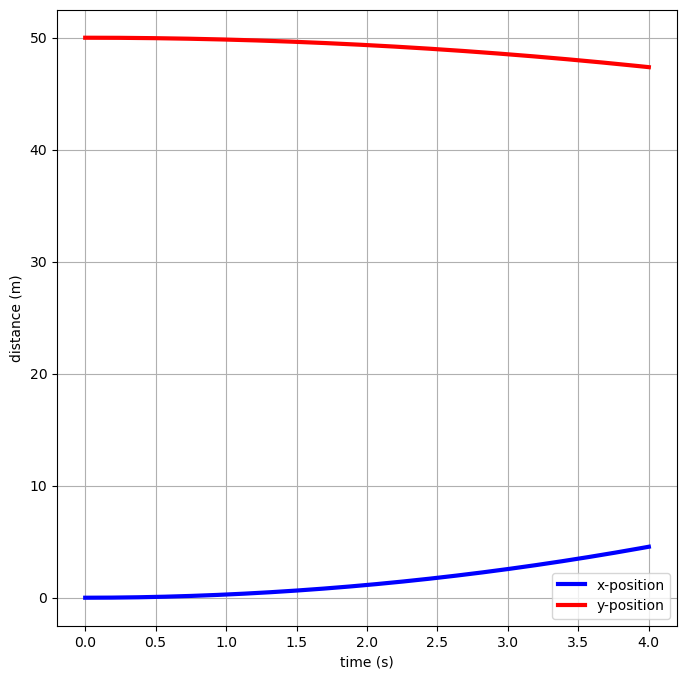

In [41]:
plt.figure(figsize=(8, 8))
plt.plot(t, X_sol_numeric, lw=3, c='blue', label='x-position')
plt.plot(t, Y_sol_numeric, lw=3, c='red', label='y-position')
plt.xlabel('time (s)')
plt.ylabel('distance (m)')
plt.legend()
plt.grid()
plt.show()

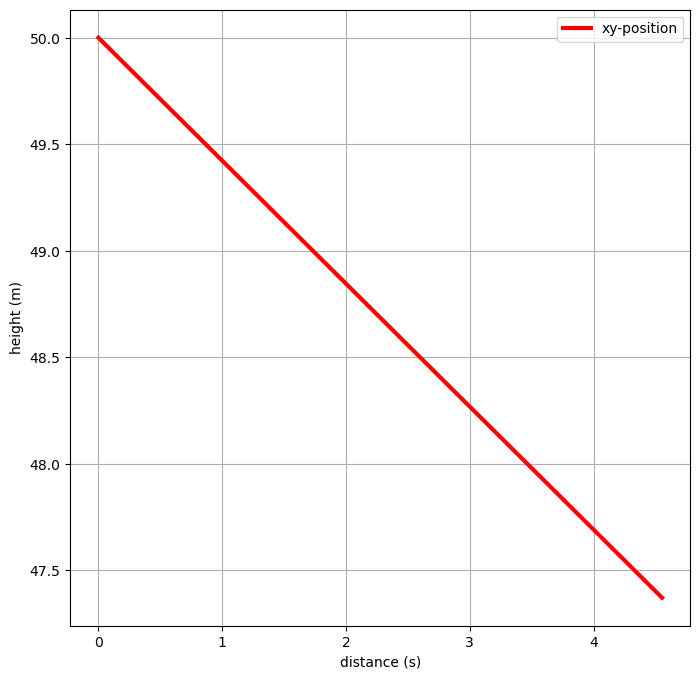

In [42]:
plt.figure(figsize=(8, 8))
plt.plot(X_sol_numeric, Y_sol_numeric, lw=3, c='red', label='xy-position')
plt.xlabel('distance (s)')
plt.ylabel('height (m)')
plt.legend()
plt.grid()
plt.show()